Base repo of data: https://github.com/mlsedigital/SPL-open-data

Great xyz data dict: https://www.inpredictable.com/2021/01/nba-player-shooting-motions-data-dump.html


## Ultimate Goals:
* Find optimal shooting form/release point
  * Include the feedback system based on optimal shooting form and release point
  * ### Use shooting meter from NBA 2k to show good vs bad releases and body movements
  * ^use the motions that:
    * produce good results (a make or enough kinetic energy for a near make)
    * are within certain boundaries where the player is comfortable AND in right shooting form
    * are within certain ranges (this inch to this inch is the best motion area for this player, etc.)
    * Compared to Popular Shooters to make recommendations to shoot more like someone like Klay Thompson or Buddy Hield (see if the data from the xyz data dictionary has good shooters to make recommendations to shoot like them)
* Exhaustion levels and optimal energy max and min
* Shot outcome prediction


1. Finding Optimal Shooting Form/Release Point

    Detailed Analysis of Body Movements: Include analysis of body kinematics (positions and velocities of limbs) at the time of release. Use joint coordinates to extract features like elbow angle, shoulder rotation, and wrist flexion at the release frame.
    Machine Learning for Form Classification: Train a model to classify "good" vs. "bad" shooting forms using successful shot data (makes or near-makes) and compare them against unsuccessful shots.
    Feedback Mechanism: Implement a feedback system that suggests adjustments based on the comparison of current shooting mechanics to historical optimal ones.

2. Shooting Meter Simulation (NBA 2K-Style)

    Visual Feedback System: Develop a visualization tool that overlays a “meter” on shot video frames, indicating the quality of the release in real-time. This can be based on a scoring function derived from the shooting form features and ball dynamics.
    Comfort Zone Identification: Use clustering algorithms (e.g., K-means) to identify comfortable ranges of motion based on historical shooting data for individual players.

3. Shot Outcome Prediction

    Feature Engineering for Outcome Modeling: Include additional features such as:
        Kinetic Energy Calculation: KE=12mv2KE=21​mv2 to see if the ball had sufficient energy for a make.
        Entry Angle and Trajectory Analysis: Analyze whether the angle at which the ball approaches the hoop aligns with optimal scoring trajectories.
    Model Development: Build a machine learning model (e.g., logistic regression, XGBoost) that predicts shot outcomes based on ball speed, entry angle, release point, and body dynamics.
    Training with Data Augmentation: Use synthetic data generation to include a wide variety of shot scenarios.

4. Exhaustion Levels and Energy Management

    Tracking Player Movements: Use the coordinates of major joints (e.g., knees, hips) to estimate a player's exertion level using metrics like the average vertical displacement over time.
    Velocity and Acceleration Patterns: Monitor changes in the velocity and acceleration of the player's body parts throughout a game to detect fatigue.
    Feature Integration: Create features such as average speed and distance covered leading up to the shot to include in the predictive model.

5. shot simulator: 
    if by these metrics we can simulate the shot to a nearby hoop. We can set the hoop in a set location (or when using spatial, we'd pick the location), and set it up to virtualize the experience with yolo/opencv where when you make those motions to show shooting motion, you can show where the ball might go (even without a ball in hand).

# ML Dataset Pipeline:
    - categorize data
    - multicollinearity/feature importances = feature selection
    - preprocessing suggestions, datasets, preprocessing with strict guidelines
    - ml model selection
    - ml model testing
    - ml data inverse transform
    - ml model prediction
    - live prediction and re-calculate the dataset formulas for when new data attaches
    - get optimal ranges for the angles (knee/wrist/elbow) and input them into the meters
    - input the meters into a video for optimal angles
    - add in ml classification with re-calculation
    - live camera feed with this? 
      - streamlit example of how this works with li


In [14]:
%%writefile ml/feature_selection/multicollinearity_checker.py

import pandas as pd
import numpy as np

def check_multicollinearity(df, threshold=0.8, debug=False):
    """
    Identifies pairs of features with correlation above the specified threshold.
    Args:
        df (DataFrame): DataFrame containing numerical features.
        threshold (float): Correlation coefficient threshold.
        debug (bool): If True, prints debugging information.
    Returns:
        DataFrame: Pairs of features with high correlation.
    """
    # Select only numerical columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    if debug:
        print(f"Computing correlation matrix for {len(numeric_df.columns)} numerical features...")

    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify highly correlated features
    highly_correlated = [
        (column, idx, upper.loc[column, idx])
        for column in upper.columns
        for idx in upper.index
        if (upper.loc[column, idx] > threshold)
    ]

    multicollinearity_df = pd.DataFrame(highly_correlated, columns=['Feature1', 'Feature2', 'Correlation'])

    if debug:
        if not multicollinearity_df.empty:
            print(f"Found {len(multicollinearity_df)} pairs of highly correlated features:")
            print(multicollinearity_df)
        else:
            print("No highly correlated feature pairs found.")

    return multicollinearity_df




if __name__ == "__main__":
    import pickle
    # Load the category bin configuration
    with open('../../data/model/pipeline/category_bin_config.pkl', 'rb') as f:
        loaded_category_bin_config = pickle.load(f)

    file_path = "../../data/processed/final_ml_dataset.csv"
    #import ml dataset from spl_dataset_prep
    final_ml_df = pd.read_csv(file_path)
    
    # Feature selection based on multi collinearity and random forest importance selection
    target_variable = 'result'
    correlation_threshold = 0.8
    debug = True

    # Remove columns to address collinearity
    drop_features = [ 'L_KNEE_min_power', 'L_HIP_max_power']
    
    # Step 1: Check for multicollinearity
    print("\nChecking for Multicollinearity...")
    multicollinearity_df = check_multicollinearity(final_ml_df, threshold=correlation_threshold, debug=debug)

    # Step 2: Handle multicollinearity
    if not multicollinearity_df.empty:
        for index, row in multicollinearity_df.iterrows():
            feature1, feature2, correlation = row['Feature1'], row['Feature2'], row['Correlation']
            print(f"High correlation ({correlation}) between '{feature1}' and '{feature2}'.")
    else:
        print("No multicollinearity issues detected.")


Overwriting ml/feature_selection/multicollinearity_checker.py


In [3]:
# %%writefile ml/feature_selection/feature_importance_calculator.py
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import logging
import pickle
from typing import Optional, List, Dict, Any, Tuple, Union
import numpy as np
from pathlib import Path
import os

def calculate_feature_importance(
    df: pd.DataFrame,
    target_variable: Union[str, List[str]],
    n_estimators: int = 100,
    random_state: int = 42,
    debug: bool = False
) -> pd.DataFrame:
    """
    Calculates feature importance using a Random Forest model.
    
    Args:
        df (DataFrame): Input DataFrame.
        target_variable (str or list of str): Target column name or a list with a single target column.
        n_estimators (int): Number of trees in the forest.
        random_state (int): Random seed.
        debug (bool): If True, prints debugging information.
    
    Returns:
        DataFrame: Feature importances.
    
    Note:
        If target_variable is passed as a list, it must contain only one element.
    """
    # Normalize the target variable: if provided as a list, extract the single string.
    if isinstance(target_variable, list):
        if len(target_variable) == 1:
            target = target_variable[0]
        else:
            raise ValueError("calculate_feature_importance supports only a single target variable.")
    else:
        target = target_variable

    # Drop the target column from predictors and extract the target variable column.
    X = df.drop(columns=[target])
    y = df[target]
    
    # If y is a DataFrame (e.g. if someone mistakenly passed a list with more than one column),
    # you might need to extract a Series. Here, we assume y is a Series.
    if isinstance(y, pd.DataFrame):
        # If a single-column DataFrame, convert to Series.
        if y.shape[1] == 1:
            y = y.iloc[:, 0]
        else:
            raise ValueError("The target variable DataFrame should contain only one column.")

    # Encode target variable if necessary
    if y.dtype == 'object' or str(y.dtype) == 'category':
        if debug:
            print(f"Target variable '{target}' is categorical. Encoding labels.")
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Separate categorical and numerical features
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

    if debug:
        print(f"Categorical columns: {categorical_cols}")
        print(f"Numerical columns: {numeric_cols}")

    # Encode categorical features if present
    if categorical_cols:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_encoded = ohe.fit_transform(X[categorical_cols])
        X_encoded_df = pd.DataFrame(
            X_encoded,
            columns=ohe.get_feature_names_out(categorical_cols),
            index=X.index
        )
        X = pd.concat([X[numeric_cols], X_encoded_df], axis=1)

    # Select the model based on the type of y
    model = (
        RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
        if y.dtype in ['int64', 'float64'] else
        RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    )

    if debug:
        print(f"Training Random Forest model with {n_estimators} estimators...")

    model.fit(X, y)

    # Calculate feature importances and return them as a DataFrame.
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    if debug:
        print("Feature Importances:")
        print(feature_importances)

    return feature_importances


def manage_features(
    mode: str,
    features_df: Optional[pd.DataFrame] = None,
    ordinal_categoricals: Optional[List[str]] = None,
    nominal_categoricals: Optional[List[str]] = None,
    numericals: Optional[List[str]] = None,
    y_variable: Optional[Union[str, List[str]]] = None,
    paths: Optional[Dict[str, str]] = None,
    base_dir: Optional[Union[str, Path]] = None
) -> Optional[Dict[str, Any]]:
    """
    Save or load features and metadata.

    Parameters:
        mode (str): "save" or "load".
        features_df (pd.DataFrame, optional): DataFrame containing features (required for "save").
        ordinal_categoricals (list, optional): List of ordinal categorical features.
        nominal_categoricals (list, optional): List of nominal categorical features.
        numericals (list, optional): List of numerical features.
        y_variable (str or list of str, optional): Target variable.
        paths (dict, optional): Dictionary mapping item keys to file names.
        base_dir (str or Path, optional): Base directory where files should be saved or loaded from.

    Returns:
        For "load" mode, returns a dictionary of loaded items; for "save" mode, returns None.
    """
    # Ensure base_dir is a Path object and resolve it
    if base_dir is None:
        base_dir = Path.cwd()
    else:
        base_dir = Path(base_dir).resolve()

    # Set default file names joined with the base directory.
    default_paths = {
        'features': str(base_dir / 'final_ml_df_selected_features_columns.pkl'),
        'ordinal_categoricals': str(base_dir / 'ordinal_categoricals.pkl'),
        'nominal_categoricals': str(base_dir / 'nominal_categoricals.pkl'),
        'numericals': str(base_dir / 'numericals.pkl'),
        'y_variable': str(base_dir / 'y_variable.pkl')
    }

    # If a paths dictionary is provided, update the defaults.
    if paths:
        default_paths.update(paths)

    try:
        if mode == 'save':
            if features_df is None:
                raise ValueError("features_df must be provided in 'save' mode.")

            data_to_save = {
                'features': features_df.columns.tolist(),
                'ordinal_categoricals': ordinal_categoricals,
                'nominal_categoricals': nominal_categoricals,
                'numericals': numericals,
                'y_variable': y_variable
            }

            # Create necessary directories and save each item.
            for key, file_path in default_paths.items():
                file_path_obj = Path(file_path)
                file_path_obj.parent.mkdir(parents=True, exist_ok=True)
                with open(file_path_obj, 'wb') as f:
                    pickle.dump(data_to_save[key], f)
                print(f"✅ {key.replace('_', ' ').capitalize()} saved to {file_path_obj}")

        elif mode == 'load':
            loaded_data = {}
            for key, file_path in default_paths.items():
                file_path_obj = Path(file_path)
                if not file_path_obj.exists():
                    print(f"❌ {key.replace('_', ' ').capitalize()} file not found at {file_path_obj}")
                    loaded_data[key] = None
                else:
                    with open(file_path_obj, 'rb') as f:
                        loaded_data[key] = pickle.load(f)
                    print(f"✅ {key.replace('_', ' ').capitalize()} loaded from {file_path_obj}")
            return loaded_data

        else:
            raise ValueError("Mode should be either 'save' or 'load'.")

    except Exception as e:
        print(f"❌ Error during '{mode}' operation: {e}")
        if mode == 'load':
            return {key: None for key in default_paths.keys()}
        

if __name__ == "__main__":
    # For testing purposes: load dataset and run feature importance.

    final_ml_features_path = str(Path("../../data/preprocessor") / "features_info" / "final_ml_df_selected_features_columns.pkl")
    # (Other paths omitted for brevity.)

    file_path = "../../data/processed/final_ml_dataset.csv"
    final_ml_df = pd.read_csv(file_path)

    # For demonstration, set the target variable as a list.
    target_variable = ['result']
    correlation_threshold = 0.8
    debug = True

    # (Assume check_multicollinearity is defined elsewhere.)
    from ml.feature_selection.multicollinearity_checker import check_multicollinearity

    print("\nChecking for Multicollinearity...")
    multicollinearity_df = check_multicollinearity(final_ml_df, threshold=correlation_threshold, debug=debug)

    if multicollinearity_df.empty:
        print("No multicollinearity issues detected.")
    else:
        for _, row in multicollinearity_df.iterrows():
            print(f"High correlation ({row['Correlation']}) between '{row['Feature1']}' and '{row['Feature2']}'.")

    # Calculate feature importance.
    print("\nCalculating Feature Importance...")
    feature_importances = calculate_feature_importance(
        final_ml_df, target_variable=target_variable, n_estimators=100, random_state=42, debug=debug
    )
    print("\nFinal Feature Importances:")
    print(feature_importances.to_string(index=False))

    
    #Final Decisions: 
    # Features recommended for dropping
    features_to_drop = [
        'peak_height_relative'
    ]
    print(f"Dropped features (for redundancy or multicollinearity): {', '.join(features_to_drop)}")
    

    # Define categories and column names
    ordinal_categoricals = []
    nominal_categoricals = [] #'player_estimated_hand_length_cm_category'
    numericals = [        'release_ball_direction_x' ,'release_ball_direction_z', 'release_ball_direction_y',
        'R_ELBOW_release_angle', 'R_ELBOW_max_angle',
        'R_WRIST_release_angle', 'R_WRIST_max_angle',
        'R_KNEE_release_angle', 'R_KNEE_max_angle',
        'release_ball_speed', 'calculated_release_angle',
        'release_ball_velocity_x', 'release_ball_velocity_y','release_ball_velocity_z']
    y_variable = ['result']
    final_keep_list = ordinal_categoricals + nominal_categoricals + numericals + y_variable
    
    # Apply the filter to keep only these columns
    final_ml_df_selected_features = final_ml_df[final_keep_list]
    print(f"Retained {len(final_keep_list)} features: {', '.join(final_keep_list)}")

    # Save feature names to a file
    with open(final_ml_features_path, 'wb') as f:
        pickle.dump(final_ml_df_selected_features.columns.tolist(), f)

    print(f"Retained {len(final_keep_list)} features: {', '.join(final_keep_list)}")

    # You might also load your config and then get base_dir from config.paths.processed_data_dir joined with config.paths.data_dir
    base_dir = Path("../../data") / "preprocessor" / "features_info"
    paths = {
        "features": str(base_dir / "final_ml_df_selected_features_columns.pkl"),
        "ordinal_categoricals": str(base_dir / "ordinal_categoricals.pkl"),
        'nominal_categoricals': str(base_dir /'nominal_categoricals.pkl'),
        'numericals': str(base_dir /'numericals.pkl'),
        'y_variable': str(base_dir /'y_variable.pkl')
    }

    # Save features and metadata
    manage_features(
        mode='save',
        features_df=final_ml_df_selected_features,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        y_variable=y_variable,
        paths=paths,
        base_dir=base_dir
    )

    # Later, load features and metadata
    loaded = manage_features(
        mode='load',
        paths=paths,
        base_dir=base_dir
    )
    print("\n📥 Loaded Data from:", base_dir)
    print("\n📥 Loaded Data:")
    print("Features:", loaded.get('features'))
    print("Ordinal Categoricals:", loaded.get('ordinal_categoricals'))
    print("Nominal Categoricals:", loaded.get('nominal_categoricals'))
    print("Numericals:", loaded.get('numericals'))
    print("Y Variable:", loaded.get('y_variable'))



Checking for Multicollinearity...
Computing correlation matrix for 138 numerical features...
Found 433 pairs of highly correlated features:
                   Feature1                Feature2  Correlation
0         L_ANKLE_max_power       L_ANKLE_std_power     0.925380
1         R_ANKLE_max_power       R_ANKLE_std_power     0.909245
2          L_KNEE_max_power        R_KNEE_max_power     0.858762
3          L_KNEE_avg_power        R_KNEE_avg_power     0.918763
4          L_KNEE_avg_power         L_HIP_avg_power     0.804101
..                      ...                     ...          ...
428  L_1STFINGER_energy_std  L_5THFINGER_energy_std     0.989249
429  L_1STFINGER_energy_std  R_5THFINGER_energy_std     0.962547
430  R_1STFINGER_energy_std  L_5THFINGER_energy_std     0.934655
431  R_1STFINGER_energy_std  R_5THFINGER_energy_std     0.995210
432  L_5THFINGER_energy_std  R_5THFINGER_energy_std     0.939738

[433 rows x 3 columns]
High correlation (0.9253798811958034) between 'L_ANKLE_

https://chatgpt.com/c/67583ce6-82ac-8012-b1d7-c415f658caa0

In [16]:
%%writefile ml/config/config_models.py
from pydantic import BaseModel, Field
from typing import List, Dict, Optional
from omegaconf import OmegaConf
from pathlib import Path
class FeaturesConfig(BaseModel):
    ordinal_categoricals: List[str] = []
    nominal_categoricals: List[str] = []
    numericals: List[str]
    y_variable: List[str]

class PathsConfig(BaseModel):
    data_dir: str = "../../data/preprocessor"  # Unified base for preprocessor outputs
    raw_data: str = "../processed/final_ml_dataset.csv"
    processed_data_dir: str = "processed"
    features_metadata_file: str = "features_info/final_ml_df_selected_features_columns.pkl"
    predictions_output_dir: str = "../../data/predictions"
    config_file: str = "../../data/model/preprocessor_config/preprocessor_config.yaml"
    log_dir: str = "../../data/preprocessor/logs"
    model_save_base_dir: str = "../../data/model"
    transformers_save_base_dir: str = "../../data/preprocessor/transformers"
    plots_output_dir: str = "../../data/preprocessor/plots"
    training_output_dir: str = "../../data/preprocessor/training_output"
    log_file: Optional[str] = "../../data/preprocessor/prediction.log"


class ModelsConfig(BaseModel):
    selected_models: List[str] = Field(default_factory=lambda: ["XGBoost", "Random Forest", "Decision Tree, CatBoost"])
    selection_metric: str = "Log Loss"
    Tree_Based_Classifier: Optional[Dict] = {}

class LoggingConfig(BaseModel):
    level: str = "INFO"
    debug: bool = False

class AppConfig(BaseModel):
    # Make sure this is now a plain list
    model_types: List[str]
    model_sub_types: Dict[str, List[str]]
    features: FeaturesConfig
    paths: PathsConfig
    models: ModelsConfig
    logging: LoggingConfig = LoggingConfig()   # default provided if missing
    execution: Optional[Dict] = {}


def load_config(config_path: Path) -> AppConfig:
    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)
    print("DEBUG: Loaded configuration dictionary:", cfg_dict)
    app_config = AppConfig(**cfg_dict)
    print(f"[Config Loader] ✅ Successfully loaded configuration from {config_path}")
    return app_config


if __name__ == "__main__":
    import json
    config = load_config(Path('../../data/model/preprocessor_config/preprocessor_config.yaml'))
    print(json.dumps(config.model_dump(), indent=2))

Overwriting ml/config/config_models.py


In [17]:
%%writefile ml/config/config_loader.py
from pathlib import Path
from omegaconf import OmegaConf
from ml.config.config_models import AppConfig

def load_config(config_path: Path) -> AppConfig:
    """
    Load the configuration from a YAML file using OmegaConf and convert it into a typed AppConfig object.
    
    Args:
        config_path (Path): Path to the YAML configuration file.
    
    Returns:
        AppConfig: A validated configuration instance.
    """
    try:
        # Load the YAML configuration with OmegaConf
        cfg = OmegaConf.load(config_path)
        # Convert the DictConfig to a regular dict (resolving variables, if any)
        cfg_dict = OmegaConf.to_container(cfg, resolve=True)
        # Use the Pydantic model for validation and type safety.
        app_config = AppConfig(**cfg_dict)
        print(f"[Config Loader] ✅ Successfully loaded configuration from {config_path}")
        return app_config
    except Exception as e:
        print(f"[Config Loader] ❌ Failed to load configuration: {e}")
        raise


Overwriting ml/config/config_loader.py


In [6]:
%%writefile ml/train_utils/train_utils.py


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration

import joblib
import os
import logging
import pandas as pd
from pathlib import Path
from typing import Any

# Local imports
from ml.feature_selection.data_loader_post_select_features import load_selected_features_data

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    logger.info(f"Predictions: {y_pred}")
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "Log Loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    with open(save_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    return metrics


def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model and preprocessing steps to disk.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - preprocessing_steps: Dictionary of preprocessing objects (e.g., encoders, scalers).
    - save_dir: Directory to save the model and preprocessing steps.
    """
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")

    # Save the model
    joblib.dump(model, model_path)
    logger.info(f"Model saved to {model_path}")


def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model


# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        explained_variance = pca.explained_variance_ratio_
        logger.info(f"PCA explained variance ratios: {explained_variance}")
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
    )
    logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")

    # Flatten the grid arrays and combine into a single array
    grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
    logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        logger.info("Inverse transforming grid points back to original feature space for prediction.")
        grid_points_original = pca.inverse_transform(grid_points_2d)
        logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
        # Predict on the grid points in original feature space
        try:
            Z = model.predict(grid_points_original)
        except ValueError as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        Z = model.predict(grid_points_original)

    Z = Z.reshape(xx.shape)
    logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")

    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
    plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
    plt.show()

# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric, #accuracy, neg_log_loss
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for CatBoost
def tune_catboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for CatBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'iterations': Integer(100, 500),
        'depth': Integer(3, 10),
        'l2_leaf_reg': Real(1, 10),
        'bagging_temperature': Real(0, 1),
        'border_count': Integer(32, 255)
    }
    logger.info(f"Parameter space for CatBoost: {param_space}")

    # Note: CatBoostClassifier might print a lot of output by default.
    # We disable verbose by setting verbose=0.
    search = BayesSearchCV(
        CatBoostClassifier(random_state=42, thread_count=-1, verbose=0),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found for CatBoost: {search.best_params_}")
    logger.info(f"Best cross-validation score for CatBoost: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_




def bayes_best_model_train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    selection_metric: str,
    model_save_dir: Path,
    classification_save_path: Path,
    tuning_results_save: Path,
    selected_models: Any,
    use_pca: bool = False
):
    """
    Streamlined function for model tuning, evaluation, and saving the best model.
    """
    logger.info("Starting the Bayesian hyperparameter tuning process...")

    # Scoring metric selection
    scoring_metric = "neg_log_loss" if selection_metric.lower() == "log loss" else "accuracy"

    # Prepare model registry
    model_registry = {
        "XGBoost": tune_xgboost,
        "Random Forest": tune_random_forest,
        "Decision Tree": tune_decision_tree,
        "CatBoost": tune_catboost
    }

    # Normalize selected_models input
    if isinstance(selected_models, str):
        selected_models = [selected_models]
    elif not selected_models:
        selected_models = list(model_registry.keys())
        logger.info(f"No models specified. Using all available: {selected_models}")

    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    # Ensure model_save_dir exists
    model_save_dir.mkdir(parents=True, exist_ok=True)
    logger.debug(f"Ensured that the model save directory '{model_save_dir}' exists.")

    # Define metric key mapping
    metric_key_mapping = {
        "log loss": "Log Loss",
        "accuracy": "Accuracy",
        "precision": "Precision",
        "recall": "Recall",
        "f1 score": "F1 Score",
        "roc auc": "ROC AUC"
    }

    # Loop over requested models
    for model_name in selected_models:
        if model_name not in model_registry:
            logger.warning(f"Unsupported model: {model_name}. Skipping.")
            continue
        try:
            logger.info(f"📌 Tuning hyperparameters for {model_name}...")
            tuner_func = model_registry[model_name]

            best_params, best_score, best_estimator = tuner_func(
                X_train, y_train, scoring_metric=scoring_metric
            )
            logger.info(f"✅ {model_name} tuning done. Best Params: {best_params}, Best CV Score: {best_score}")

            # Evaluate on X_test
            metrics = evaluate_model(best_estimator, X_test, y_test, save_path=classification_save_path)
            metric_key = metric_key_mapping.get(selection_metric.lower(), selection_metric)
            metric_value = metrics.get(metric_key)

            # Debugging
            logger.debug(f"Selection Metric Key: {metric_key}")
            logger.debug(f"Available Metrics: {metrics.keys()}")

            if metric_value is not None:
                logger.debug(f"Metric value for {selection_metric}: {metric_value}")
                if best_metric_value is None:
                    best_metric_value = metric_value
                    best_model_name = model_name
                    best_model = best_estimator
                    logger.debug(f"Best model set to {best_model_name} with {selection_metric}={best_metric_value}")
                else:
                    # For log loss, lower is better
                    if selection_metric.lower() == "log loss" and metric_value < best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
                    # For other metrics (accuracy, f1, etc.), higher is better
                    elif selection_metric.lower() != "log loss" and metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
            else:
                logger.debug(f"Metric value for {selection_metric} is None. Best model not updated.")

            # Save partial results
            tuning_results[model_name] = {
                "Best Params": best_params,
                "Best CV Score": best_score,
                "Evaluation Metrics": metrics,
            }

            # Plot boundary (optional for tree-based with PCA)
            try:
                plot_decision_boundary(best_estimator, X_test, y_test, f"{model_name} Decision Boundary", use_pca=use_pca)
            except ValueError as e:
                logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")

            # Add feature importance plots for XGBoost
            if model_name.lower() == "xgboost":
                logger.info("Generating feature importance plots for XGBoost...")
                try:
                    xgb.plot_importance(best_model, importance_type="weight")
                    plt.title("Feature Importance by Weight")
                    plt.show()

                    xgb.plot_importance(best_model, importance_type="cover")
                    plt.title("Feature Importance by Cover")
                    plt.show()

                    xgb.plot_importance(best_model, importance_type="gain")
                    plt.title("Feature Importance by Gain")
                    plt.show()
                except Exception as e:
                    logger.error(f"Error generating feature importance plots: {e}")
        except Exception as e:
            logger.error(f"❌ Error tuning {model_name}: {e}")
            continue

    # Save best model information
    if best_model_name:
        logger.info(f"✅ Best model is {best_model_name} with {selection_metric}={best_metric_value}")
        try:
            save_model(best_model, best_model_name, save_dir=model_save_dir)
            logger.info(f"✅ Model '{best_model_name}' saved successfully in '{model_save_dir}'.")
        except Exception as e:
            logger.error(f"❌ Failed to save best model {best_model_name}: {e}")
            raise  # Ensure the exception is propagated

        # Add Best Model info to tuning_results
        tuning_results["Best Model"] = {
            "model_name": best_model_name,
            "metric_value": best_metric_value,
            "path": str(Path(model_save_dir) / best_model_name.replace(" ", "_") / 'trained_model.pkl')
        }
    else:
        logger.warning("⚠️ No best model was selected. Tuning might have failed for all models.")

    # Save tuning results
    try:
        with tuning_results_save.open("w") as f:
            json.dump(tuning_results, f, indent=4)
        logger.info(f"✅ Tuning results saved to {tuning_results_save}.")
    except Exception as e:
        logger.error(f"❌ Error saving tuning results: {e}")

Overwriting ml/train_utils/train_utils.py


WE'RE IN THIS DIRECTORY = /workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/notebooks/freethrow_predictions
WE'RE IN THIS sys.path = ['/opt/conda/envs/data_science_ft_bio_predictions/lib/python310.zip', '/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10', '/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/lib-dynload', '', '/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/site-packages']
[Config Loader] ✅ Successfully loaded configuration from ../../data/model/preprocessor_config/preprocessor_config.yaml
Selected Models: ['XGBoost', 'Random Forest', 'Decision Tree', 'CatBoost']


2025-04-07 20:00:36,071 - INFO - ✅ Loaded dataset from /workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/data/preprocessor/../../data/processed/final_ml_dataset.csv. Shape: (125, 146)
2025-04-07 20:00:36,198 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.
2025-04-07 20:00:36,198 - INFO - Starting: Final Preprocessing Pipeline in 'train' mode.
2025-04-07 20:00:36,201 [INFO] Step: filter_columns
2025-04-07 20:00:36,201 - INFO - Step: filter_columns
2025-04-07 20:00:36,213 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)
2025-04-07 20:00:36,213 - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)
2025-04-07 20:00:36,215 [INFO] ✅ Column filtering completed successfully.
2025-04-07 20:00:36,215 - INFO - ✅ Column filtering completed successfully.
2025-04-07 20:00:36,225 [INFO] Step: Split Dataset into Train and Test
2025-04-07 20:00:36,225 - INFO - Step: Split Dataset into Train and Test
2025-04-07 20:00

✅ Features loaded from ../../data/preprocessor/features_info/final_ml_df_selected_features_columns.pkl
✅ Ordinal categoricals loaded from ../../data/preprocessor/features_info/ordinal_categoricals.pkl
✅ Nominal categoricals loaded from ../../data/preprocessor/features_info/nominal_categoricals.pkl
✅ Numericals loaded from ../../data/preprocessor/features_info/numericals.pkl
✅ Y variable loaded from ../../data/preprocessor/features_info/y_variable.pkl
Numericals: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'R_ELBOW_release_angle', 'R_ELBOW_max_angle', 'R_WRIST_release_angle', 'R_WRIST_max_angle', 'R_KNEE_release_angle', 'R_KNEE_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
Ordinal Categoricals: []
Nominal Categoricals: []
Y Variable: ['result']


2025-04-07 20:00:36,297 [INFO] Step 'Test for Normality' completed: Normality results computed.
2025-04-07 20:00:36,297 - INFO - Step 'Test for Normality' completed: Normality results computed.
2025-04-07 20:00:36,300 [INFO] Step: Handle Outliers
2025-04-07 20:00:36,300 - INFO - Step: Handle Outliers
2025-04-07 20:00:36,303 [INFO] Applying univariate outlier detection for classification.
2025-04-07 20:00:36,303 - INFO - Applying univariate outlier detection for classification.
2025-04-07 20:00:36,344 [INFO] Step: Generate Preprocessor Recommendations
2025-04-07 20:00:36,344 - INFO - Step: Generate Preprocessor Recommendations
2025-04-07 20:00:36,348 [INFO] Preprocessing Recommendations generated.
2025-04-07 20:00:36,348 - INFO - Preprocessing Recommendations generated.
2025-04-07 20:00:36,351 [INFO] Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.
2025-04-07 20:00:36,351 - INFO - Step 'Generate Preprocessor Recommendations' completed: Recommendations g

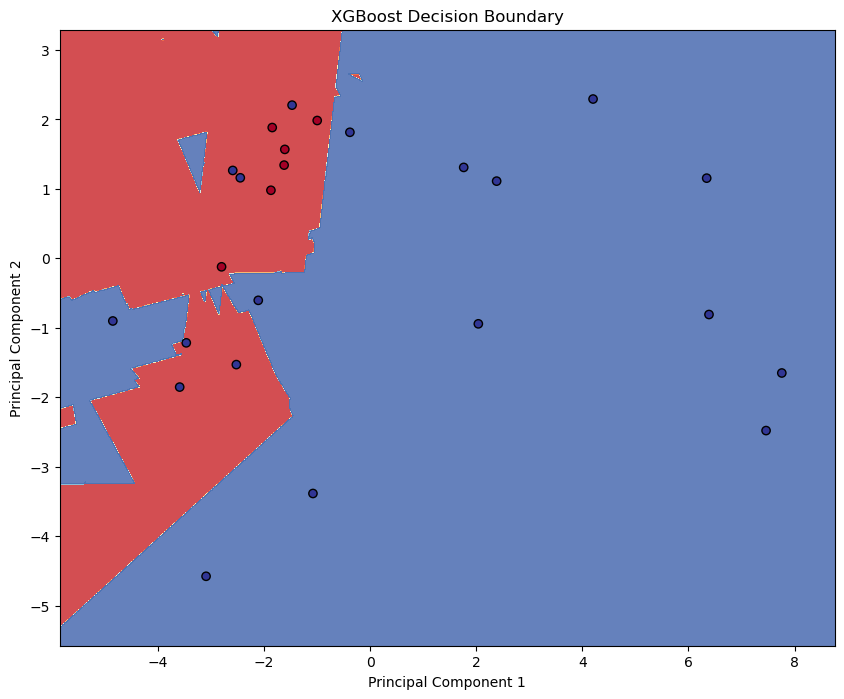

2025-04-07 20:03:12,783 - INFO - Generating feature importance plots for XGBoost...


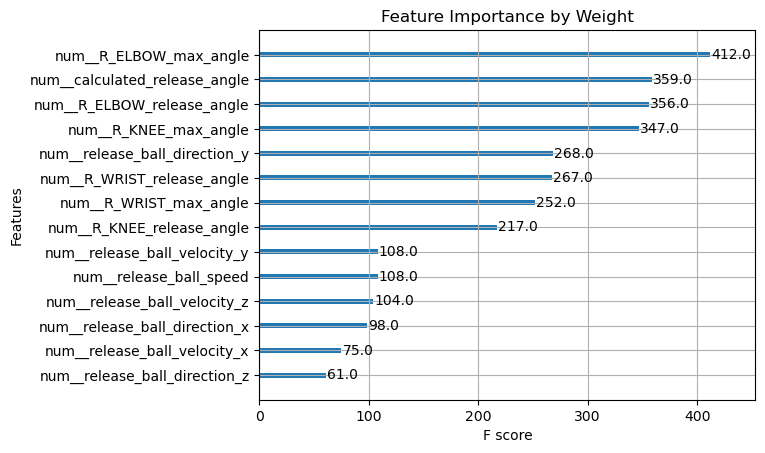

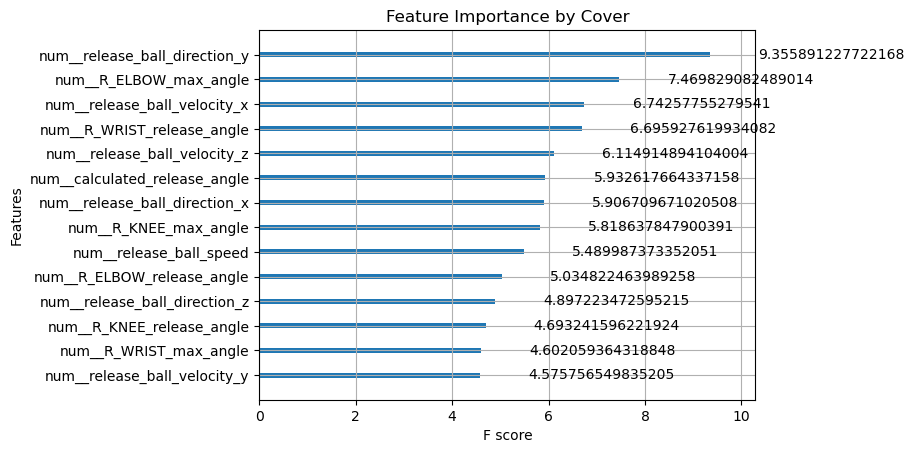

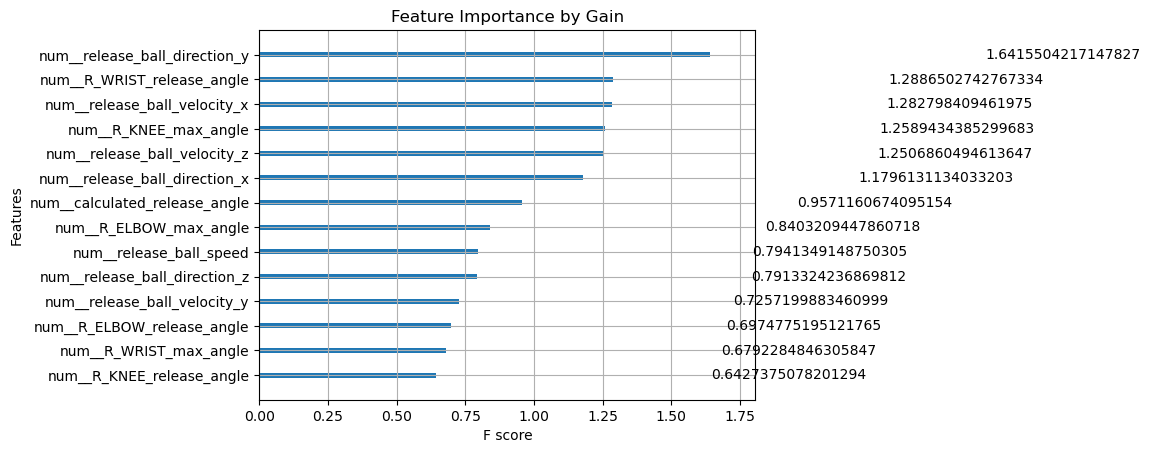

2025-04-07 20:03:13,234 - INFO - 📌 Tuning hyperparameters for Random Forest...
2025-04-07 20:03:13,235 - INFO - Starting hyperparameter tuning for Random Forest...
2025-04-07 20:03:13,239 - INFO - Parameter space: {'n_estimators': Integer(low=10, high=500, prior='uniform', transform='identity'), 'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None), 'bootstrap': Categorical(categories=(True, False), prior=None), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None)}
2025-04-07 20:06:28,474 - INFO - Best parameters found: OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 50), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 10)])
2025-04-07 20:06:

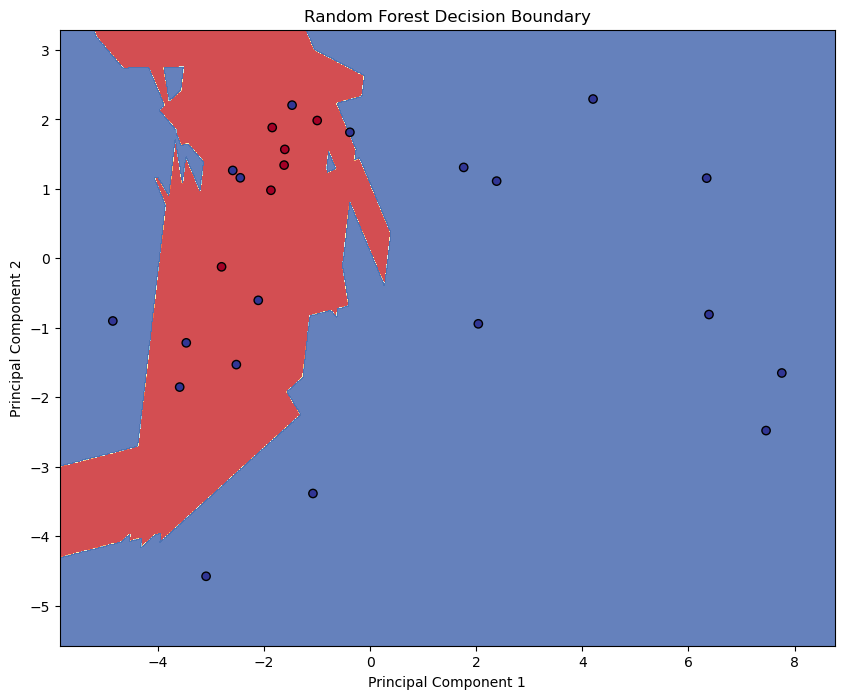

2025-04-07 20:06:29,126 - INFO - 📌 Tuning hyperparameters for Decision Tree...
2025-04-07 20:06:29,127 - INFO - Starting hyperparameter tuning for Decision Tree...
2025-04-07 20:06:29,131 - INFO - Parameter space: {'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None), 'splitter': Categorical(categories=('best', 'random'), prior=None)}
/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 50, 1, 2, 'best'] before, using random point ['gini', 25, 7, 7, 'best']
  warnings.warn(
/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The object

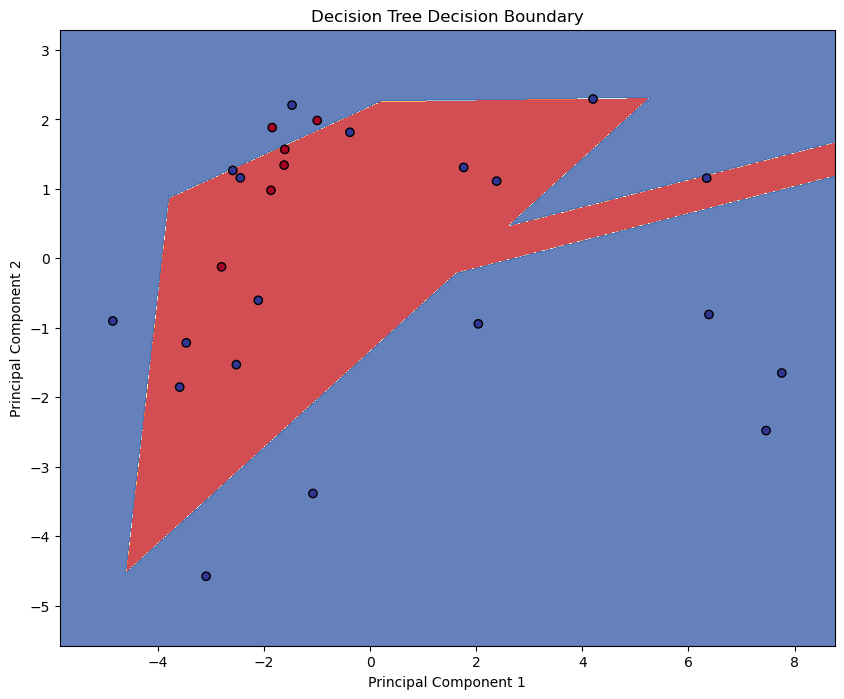

2025-04-07 20:07:45,756 - INFO - 📌 Tuning hyperparameters for CatBoost...
2025-04-07 20:07:45,757 - INFO - Starting hyperparameter tuning for CatBoost...
2025-04-07 20:07:45,761 - INFO - Parameter space for CatBoost: {'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='identity'), 'iterations': Integer(low=100, high=500, prior='uniform', transform='identity'), 'depth': Integer(low=3, high=10, prior='uniform', transform='identity'), 'l2_leaf_reg': Real(low=1, high=10, prior='uniform', transform='identity'), 'bagging_temperature': Real(low=0, high=1, prior='uniform', transform='identity'), 'border_count': Integer(low=32, high=255, prior='uniform', transform='identity')}
2025-04-07 20:13:20,088 - INFO - Best parameters found for CatBoost: OrderedDict([('bagging_temperature', 0.0), ('border_count', 38), ('depth', 6), ('iterations', 282), ('l2_leaf_reg', 1.6305415573022148), ('learning_rate', 0.10232573483248794)])
2025-04-07 20:13:20,090 - INFO - Best cross-validation

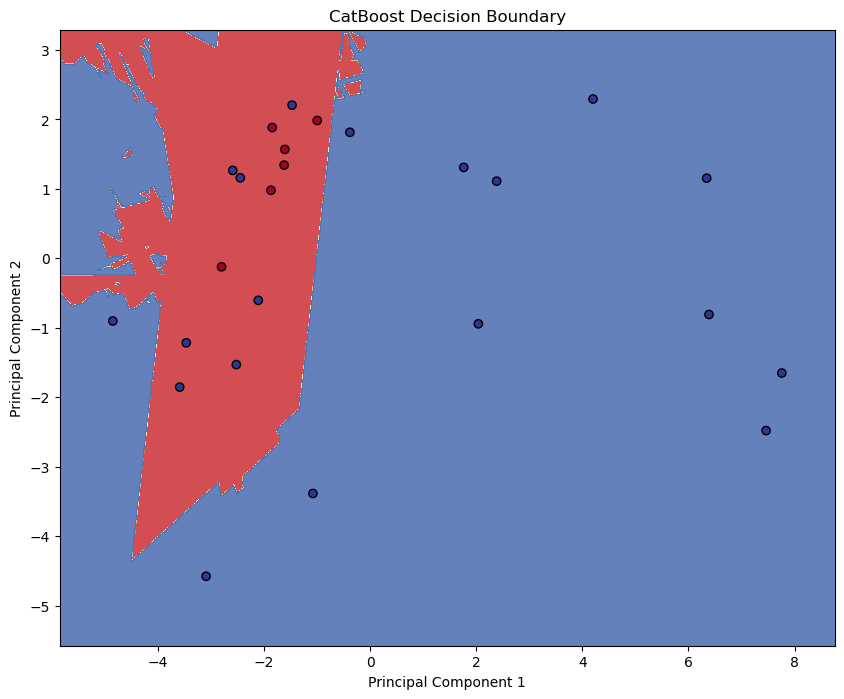

2025-04-07 20:13:25,420 - INFO - ✅ Best model is XGBoost with accuracy=0.8
2025-04-07 20:13:25,535 - INFO - Model saved to /workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/data/model/XGBoost_model.pkl
2025-04-07 20:13:25,536 - INFO - ✅ Model 'XGBoost' saved successfully in '/workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/data/model'.
2025-04-07 20:13:25,572 - INFO - ✅ Tuning results saved to /workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/data/model/tuning_results.json.
2025-04-07 20:13:25,574 - INFO - ✅ Training workflow completed successfully.


In [7]:
# %%writefile ml/train.py
import logging
from pathlib import Path
import pandas as pd
import os
import sys
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import json
from ml.config.config_loader import load_config  # New import for config
from ml.config.config_models import AppConfig
from datapreprocessor import DataPreprocessor
from ml.feature_selection.feature_importance_calculator import manage_features
from ml.train_utils.train_utils import (bayes_best_model_train
)

# Setup basic logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

print("WE'RE IN THIS DIRECTORY =", os.getcwd())
print("WE'RE IN THIS sys.path =", sys.path)

def main():
    # --- 1. Load Configuration via our new module ---
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    # load_config now returns an AppConfig instance (verified and typed)
    config: AppConfig = load_config(config_path)
    
    # --- 2. Use Config Values in the Code ---
    # Extract paths from configuration (using our typed model)
    paths_config = config.paths
    base_data_dir = Path(paths_config.data_dir).resolve()
    raw_data_file = base_data_dir / paths_config.raw_data

    # Output directories
    log_dir = Path(paths_config.log_dir).resolve()
    model_save_dir = Path(paths_config.model_save_base_dir).resolve()
    transformers_save_dir = Path(paths_config.transformers_save_base_dir).resolve()
    plots_output_dir = Path(paths_config.plots_output_dir).resolve()
    training_output_dir = Path(paths_config.training_output_dir).resolve()

    # Ensure output directories exist if needed
    model_save_dir.mkdir(parents=True, exist_ok=True)
    
    CLASSIFICATION_REPORT_PATH = model_save_dir / "classification_report.txt"
    TUNING_RESULTS_SAVE_PATH = model_save_dir / "tuning_results.json"

    # Extract model settings from the config
    selected_models = config.models.selected_models
    print(f"Selected Models: {selected_models}")
    selection_metric = config.models.selection_metric

    # Load the dataset
    try:
        filtered_df = pd.read_csv(raw_data_file)
        logger.info(f"✅ Loaded dataset from {raw_data_file}. Shape: {filtered_df.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        return
    base_dir = Path("../../data") / "preprocessor" / "features_info"
    # Load feature metadata using manage_features
    feature_paths = {
        'features': '../../data/preprocessor/features_info/final_ml_df_selected_features_columns.pkl',
        'ordinal_categoricals': '../../data/preprocessor/features_info/ordinal_categoricals.pkl',
        'nominal_categoricals': '../../data/preprocessor/features_info/nominal_categoricals.pkl',
        'numericals': '../../data/preprocessor/features_info/numericals.pkl',
        'y_variable': '../../data/preprocessor/features_info/y_variable.pkl'
    }
    loaded = manage_features(mode='load', paths=feature_paths)
    if loaded:
        y_var = loaded.get('y_variable')
        numericals = loaded.get('numericals')
        print(f"Numericals: {numericals}")
        print(f"Ordinal Categoricals: {loaded.get('ordinal_categoricals')}")
        print(f"Nominal Categoricals: {loaded.get('nominal_categoricals')}")
        print(f"Y Variable: {y_var}")
    else:
        logger.error("❌ Failed to load feature metadata.")
        return

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_var,
        ordinal_categoricals=loaded.get('ordinal_categoricals'),
        nominal_categoricals=loaded.get('nominal_categoricals'),
        numericals=loaded.get('numericals'),
        mode='train',
        debug=config.logging.debug,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=plots_output_dir,
        transformers_dir=transformers_save_dir
    )

    try:
        X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(filtered_df)
        logger.info(f"✅ Preprocessing complete. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    except Exception as e:
        logger.error(f"❌ Error during preprocessing: {e}")
        return

    # Proceed with training (tuning and model saving) using your existing function.
    try:
        bayes_best_model_train(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            selection_metric=selection_metric,
            model_save_dir=model_save_dir,
            classification_save_path=CLASSIFICATION_REPORT_PATH,
            tuning_results_save=TUNING_RESULTS_SAVE_PATH,
            selected_models=selected_models,
            use_pca=True  
        )
    except Exception as e:
        logger.error(f"❌ Model training/tuning failed: {e}")
        return

    logger.info("✅ Training workflow completed successfully.")

if __name__ == "__main__":
    main()


# Shap Functions for Prediction Module

### Prediction Module

In [2]:
# %%writefile ml/predict/predict.py

import pandas as pd
import logging
import os
import joblib
import json
from pathlib import Path
from typing import Any, Dict

# Local imports - Adjust based on your project structure
from ml.train_utils.train_utils import load_model  # Ensure correct import path
from datapreprocessor import DataPreprocessor  # Adjust as necessary

# Import new configuration loader
from ml.config.config_loader import load_config
from ml.config.config_models import AppConfig  # To use as type annotation

# Set up logger
logger = logging.getLogger("PredictAndAttachLogger")
logger.setLevel(logging.DEBUG)

# Set up console and file handlers
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
file_handler = logging.FileHandler("predictions.log")
file_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)
logger.addHandler(console_handler)
logger.addHandler(file_handler)

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def predict_and_attach_predict_probs(trained_model, X_preprocessed, X_inversed):
    # [Existing prediction code unchanged...]
    try:
        predictions = trained_model.predict(X_preprocessed)
        logger.info("✅ Predictions made successfully.")
        logger.debug(f"Predictions sample: {predictions[:5]}")
    except Exception as e:
        logger.error(f"❌ Prediction failed: {e}")
        return

    try:
        prediction_probs = trained_model.predict_proba(X_preprocessed)
        logger.info("✅ Prediction probabilities computed successfully.")
        logger.debug(f"Prediction probabilities sample:\n{prediction_probs[:2]}")
    except Exception as e:
        logger.error(f"❌ Prediction probabilities computation failed: {e}")
        return

    if hasattr(trained_model, 'classes_'):
        class_labels = trained_model.classes_
    else:
        class_labels = [f'class_{i}' for i in range(prediction_probs.shape[1])]

    try:
        if X_inversed is not None:
            if 'Prediction' not in X_inversed.columns:
                X_inversed['Prediction'] = predictions
                logger.debug("Predictions attached to inverse-transformed DataFrame.")
            if 'Prediction_Probabilities' not in X_inversed.columns:
                X_inversed['Prediction_Probabilities'] = prediction_probs.tolist()
                logger.debug("Prediction probabilities attached to inverse-transformed DataFrame.")
            for idx, label in enumerate(class_labels):
                col_name = f'Probability_{label}'
                X_inversed[col_name] = prediction_probs[:, idx]
                logger.debug(f"Attached column: {col_name}")
            X_inversed.drop(columns=['Prediction_Probabilities'], inplace=True)
            logger.debug(f"Final shape of X_inversed: {X_inversed.shape}")
            logger.debug(f"Final columns in X_inversed: {X_inversed.columns.tolist()}")
        else:
            logger.warning("X_inversed is None. Creating a new DataFrame with predictions.")
            data = {'Prediction': predictions, 'Prediction_Probabilities': prediction_probs.tolist()}
            for idx, label in enumerate(class_labels):
                col_name = f'Probability_{label}'
                data[col_name] = prediction_probs[:, idx]
            X_inversed = pd.DataFrame(data)
            X_inversed.drop(columns=['Prediction_Probabilities'], inplace=True)
            logger.debug(f"Created new X_inversed DataFrame with shape: {X_inversed.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to attach predictions to inverse-transformed DataFrame: {e}")
        X_inversed = pd.DataFrame({'Prediction': predictions})
        return

    return predictions, prediction_probs, X_inversed

def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config: AppConfig = load_config(config_path)
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return

    # ----------------------------
    # Step 2: Extract Paths from Configuration
    # ----------------------------
    data_dir = Path(config.paths.data_dir).resolve()
    raw_data_path = data_dir / config.paths.raw_data
    processed_data_dir = data_dir / config.paths.processed_data_dir
    transformers_dir = Path(config.paths.transformers_save_base_dir).resolve()
    predictions_output_dir = Path(config.paths.predictions_output_dir).resolve()
    log_dir = Path(config.paths.log_dir).resolve()
    model_save_dir = Path(config.paths.model_save_base_dir).resolve()
    log_file = config.paths.log_file

    logger.info("✅ Starting prediction module.")

    # ----------------------------
    # Step 3: Extract Feature Assets
    # ----------------------------
    features_config = config.features
    column_assets = {
        'y_variable': features_config.y_variable,
        'ordinal_categoricals': features_config.ordinal_categoricals,
        'nominal_categoricals': features_config.nominal_categoricals,
        'numericals': features_config.numericals
    }

    # ----------------------------
    # Step 4: Load Tuning Results to Find Best Model
    # ----------------------------
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        logger.error(f"❌ Tuning results not found at '{tuning_results_path}'. Cannot determine the best model.")
        return

    try:
        with open(tuning_results_path, 'r') as f:
            tuning_results = json.load(f)
        best_model_info = tuning_results.get("Best Model")
        if not best_model_info:
            logger.error("❌ Best model information not found in tuning results.")
            return
        best_model_name = best_model_info.get("model_name")
        if not best_model_name:
            logger.error("❌ Best model name not found in tuning results.")
            return
        logger.info(f"Best model identified: {best_model_name}")
    except Exception as e:
        logger.error(f"❌ Failed to load tuning results: {e}")
        return

    # ----------------------------
    # Step 5: Load the Prediction Dataset
    # ----------------------------
    if not raw_data_path.exists():
        logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
        return

    try:
        df_predict = pd.read_csv(raw_data_path)
        logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # ----------------------------
    # Step 6: Initialize DataPreprocessor
    # ----------------------------
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",  # Adjust if needed based on best_model_name
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []),
        mode='predict',
        options={},
        debug=False,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir
    )

    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
        print("X_new_preprocessed type =", type(X_preprocessed), "X_new_inverse type =", type(X_inversed))
        logger.info("✅ Preprocessing completed successfully in predict mode.")
    except Exception as e:
        logger.error(f"❌ Preprocessing failed in predict mode: {e}")
        return

    # ----------------------------
    # Step 7: Load the Best Model
    # ----------------------------
    try:
        trained_model = load_model(best_model_name, model_save_dir)
        model_path = model_save_dir / best_model_name.replace(" ", "_") / 'trained_model.pkl'
        logger.info(f"✅ Trained model loaded from '{model_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load the best model '{best_model_name}': {e}")
        return

    # ----------------------------
    # Step 8: Make Predictions and Attach Probabilities
    # ----------------------------
    predictions, prediction_probs, X_inversed = predict_and_attach_predict_probs(trained_model, X_preprocessed, X_inversed)
    print(X_inversed)

    # ----------------------------
    # Step 9: Save Predictions
    # ----------------------------
    try:
        predictions_output_dir.mkdir(parents=True, exist_ok=True)
        predictions_filename = predictions_output_dir / f'predictions_{best_model_name.replace(" ", "_")}.csv'
        X_inversed.to_csv(predictions_filename, index=False)
        logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save predictions: {e}")
        return

    logger.info(f"✅ All prediction tasks completed successfully for model '{best_model_name}'.")

if __name__ == "__main__":
    main()


2025-04-07 14:19:28,981 - PredictAndAttachLogger - INFO - ✅ Starting prediction module.
2025-04-07 14:19:28,981 - INFO - ✅ Starting prediction module.
2025-04-07 14:19:28,986 - PredictAndAttachLogger - INFO - Best model identified: XGBoost
2025-04-07 14:19:28,986 - INFO - Best model identified: XGBoost
2025-04-07 14:19:28,997 - PredictAndAttachLogger - INFO - ✅ Prediction input data loaded from '/workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/data/preprocessor/../../data/processed/final_ml_dataset.csv'.
2025-04-07 14:19:28,997 - INFO - ✅ Prediction input data loaded from '/workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/data/preprocessor/../../data/processed/final_ml_dataset.csv'.
2025-04-07 14:19:28,999 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-04-07 14:19:28,999 - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-04-07 14:19:29,000 [INFO] Step: filter_columns
2025-04-07 14:19:29,000 - INFO - Step: filter_colum

[Config Loader] ✅ Successfully loaded configuration from ../../data/model/preprocessor_config/preprocessor_config.yaml
X_new_preprocessed type = <class 'pandas.core.frame.DataFrame'> X_new_inverse type = <class 'pandas.core.frame.DataFrame'>
     release_ball_direction_x  release_ball_direction_z  \
0                    0.377012                  0.926203   
1                    0.417644                  0.901906   
2                    0.383086                  0.922353   
3                    0.292054                  0.956396   
4                    0.389917                  0.918894   
..                        ...                       ...   
120                  0.460703                  0.886986   
121                  0.411186                  0.911511   
122                  0.161727                  0.986537   
123                  0.114865                  0.966452   
124                  0.266885                  0.962290   

     release_ball_direction_y  R_ELBOW_release_an

### Bayesian Example

In [24]:
%%writefile ml/bayesian_optimization/bayesian_optimized_metrics_EXAMPLE.py

from skopt import gp_minimize
from skopt.space import Real
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

def prepare_data():
    """Prepare training data."""
    np.random.seed(42)
    X_test = pd.DataFrame({
        'knee_max_angle': np.random.uniform(40, 140, 200),
        'wrist_max_angle': np.random.uniform(0, 90, 200),
        'elbow_max_angle': np.random.uniform(30, 160, 200),
    })
    y_test = pd.Series(np.random.choice([0, 1], size=200))

    features = ['knee_max_angle', 'wrist_max_angle', 'elbow_max_angle']
    X_train = X_test[features]
    y_train = y_test

    # Debug: Check the dataset details
    print(f"X_train shape: {X_train.shape}")
    print(f"X_train sample:\n{X_train.head()}")
    print(f"y_train sample:\n{y_train.head()}")
    return X_train, y_train, features


def train_model(X_train, y_train):
    """Train a Decision Tree Classifier."""
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    # Debug: Check feature importances
    print(f"Feature importances: {clf.feature_importances_}")
    return clf


def define_search_space(features):
    """Define the search space for optimization."""
    spaces = {
        'knee_max_angle': Real(40, 140, name='knee_angle'),
        'wrist_max_angle': Real(30, 90, name='wrist_angle'),
        'elbow_max_angle': Real(30, 160, name='elbow_angle')
    }
    return [spaces[feature] for feature in features]


def objective_function(clf):
    """Create an objective function for Bayesian Optimization."""
    def objective(params):
        knee, wrist, elbow = params
        input_df = pd.DataFrame([[knee, wrist, elbow]], 
                                columns=['knee_max_angle', 'wrist_max_angle', 'elbow_max_angle'])
        success_prob = clf.predict_proba(input_df)[0, 1]
        # Debug: Log evaluation details
        print(f"Evaluating: knee={knee:.2f}, wrist={wrist:.2f}, elbow={elbow:.2f}, success_prob={success_prob:.2f}")
        return -success_prob  # Negative for minimization
    return objective


def perform_optimization(objective, space):
    """Perform Bayesian Optimization."""
    res = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=50,
        n_random_starts=10,
        random_state=42
    )
    # Debug: Log optimization result details
    print(f"Optimization result: {res}")
    return res


def calculate_baselines(X_train):
    """Calculate baseline values for each feature."""
    baselines = {col: X_train[col].mean() for col in X_train.columns}
    print(f"Baseline values: {baselines}")
    return baselines


def compare_results(features, baselines, results):
    """Compare optimal values with baselines."""
    print("\nOptimization Results:")
    for feature, baseline, optimal in zip(features, baselines.values(), results.x):
        difference = optimal - baseline
        print(f"{feature} - Optimal: {optimal:.2f}, Baseline: {baseline:.2f}, Difference: {difference:.2f}")


# Main workflow
X_train, y_train, features = prepare_data()
clf = train_model(X_train, y_train)
space = define_search_space(features)
objective = objective_function(clf)
res = perform_optimization(objective, space)
baselines = calculate_baselines(X_train)
compare_results(features, baselines, res)


Overwriting ml/bayesian_optimization/bayesian_optimized_metrics_EXAMPLE.py


2025-04-07 20:21:20,948 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-04-07 20:21:20,948 - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-04-07 20:21:20,950 [INFO] Step: filter_columns
2025-04-07 20:21:20,950 - INFO - Step: filter_columns
2025-04-07 20:21:20,954 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2025-04-07 20:21:20,954 - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2025-04-07 20:21:20,956 [INFO] ✅ Column filtering completed successfully.
2025-04-07 20:21:20,956 - INFO - ✅ Column filtering completed successfully.
2025-04-07 20:21:20,961 [INFO] Step: Preprocess Predict
2025-04-07 20:21:20,961 - INFO - Step: Preprocess Predict
2025-04-07 20:21:20,963 [INFO] Step: Load Transformers
2025-04-07 20:21:20,963 - INFO - Step: Load Transformers
2025-04-07 20:21:21,013 [INFO] Transformers loaded successfully from '/workspaces/spl_freethrow_biomechanics_analysis_ml_predi

[Config Loader] ✅ Successfully loaded configuration from ../../data/model/preprocessor_config/preprocessor_config.yaml
Config loaded from ../../data/model/preprocessor_config/preprocessor_config.yaml
Delta Threshold: 0.001, Type: <class 'float'>
n_best: 5, Type: <class 'int'>
n_calls: 50, Type: <class 'int'>
[Debug] Loaded optimization columns: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'R_ELBOW_release_angle', 'R_ELBOW_max_angle', 'R_WRIST_release_angle', 'R_WRIST_max_angle', 'R_KNEE_release_angle', 'R_KNEE_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z', 'result']
[Debug] Target variables to remove: ['result']
[Debug] Removed 'result' from optimization columns.
[Debug] Final optimization columns: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'R_ELBOW_release_angle', 'R_ELBOW_max_angle', 'R_WRIST_release_angle', 

2025-04-07 20:21:21,113 - INFO - Model loaded from /workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/data/model/XGBoost_model.pkl


[Debug] Defined search space: [Real(low=-3.3434665725259918, high=1.5403189778019535, prior='uniform', transform='identity'), Real(low=-2.09097884983127, high=2.137444663198446, prior='uniform', transform='identity'), Real(low=-5.480051576066938, high=2.0556065556165293, prior='uniform', transform='identity'), Real(low=-4.778892502654252, high=2.4938116609261143, prior='uniform', transform='identity'), Real(low=-2.9183003870090385, high=7.256523760279251, prior='uniform', transform='identity'), Real(low=-2.855338304642954, high=3.5428429179703893, prior='uniform', transform='identity'), Real(low=-2.205945815021015, high=2.8982327399252563, prior='uniform', transform='identity'), Real(low=-3.141734068587612, high=2.6387163364149187, prior='uniform', transform='identity'), Real(low=-2.7976051603030543, high=2.347417098030396, prior='uniform', transform='identity'), Real(low=-2.3739812672447034, high=2.0661652236322507, prior='uniform', transform='identity'), Real(low=-1.7389440704704782,

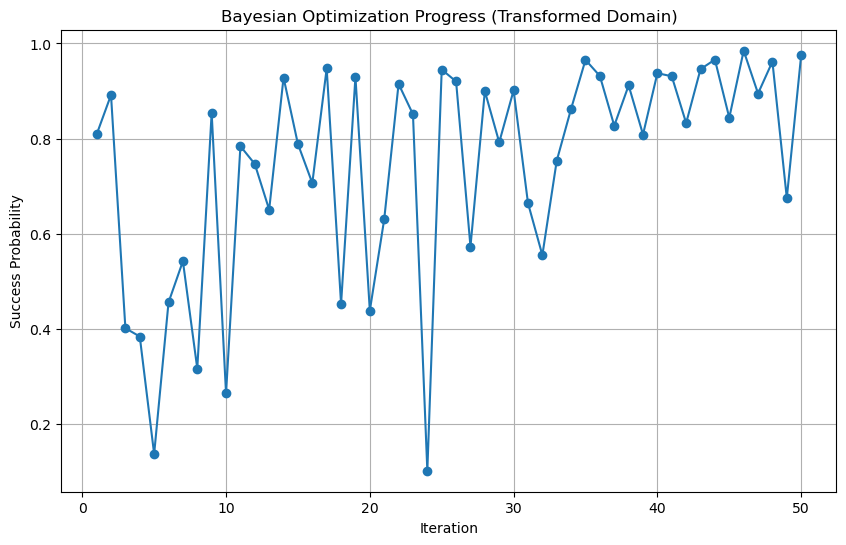

[Debug] Baseline feature vector (transformed): num__release_ball_direction_x   -0.211170
num__release_ball_direction_z    0.122501
num__release_ball_direction_y   -0.266427
num__R_ELBOW_release_angle      -0.178268
num__R_ELBOW_max_angle          -0.042633
num__R_WRIST_release_angle       0.021145
num__R_WRIST_max_angle           0.015353
num__R_KNEE_release_angle       -0.042579
num__R_KNEE_max_angle           -0.013361
num__release_ball_speed         -0.222058
num__calculated_release_angle    0.723091
num__release_ball_velocity_x    -0.207910
num__release_ball_velocity_y    -0.185908
num__release_ball_velocity_z    -0.244303
dtype: float64
[Debug] Baseline DataFrame columns: ['num__release_ball_direction_x', 'num__release_ball_direction_z', 'num__release_ball_direction_y', 'num__R_ELBOW_release_angle', 'num__R_ELBOW_max_angle', 'num__R_WRIST_release_angle', 'num__R_WRIST_max_angle', 'num__R_KNEE_release_angle', 'num__R_KNEE_max_angle', 'num__release_ball_speed', 'num__calculated_rele

In [8]:
# %%writefile ml/bayesian_optimization/bayesian_optimized_metrics.py
# previously: %%writefile ../../src/freethrow_predictions/ml/bayes_optim_angles_xgboostpreds.py
import os
from pathlib import Path
import pandas as pd
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import pickle

# Import the early stopping callback from skopt
from skopt.callbacks import DeltaYStopper

# Configuration and model utilities
from ml.config.config_loader import load_config
from ml.config.config_models import AppConfig
from ml.train_utils.train_utils import load_model

# Updated DataPreprocessor (which now returns X_inversed as part of final_preprocessing)
from datapreprocessor import DataPreprocessor
from ml.feature_selection.feature_importance_calculator import manage_features

# Simple helper for debug prints (logger removed)
def log_debug(message, debug):
    if debug:
        print(message)

def get_preprocessing_results(preprocessor, df, debug):
    """
    Run preprocessing and return X_preprocessed, X_inversed.
    We assume final_preprocessing returns: X_preprocessed, recommendations, X_inversed.
    """
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df)
        log_debug(f"[Debug] Preprocessing complete. X_preprocessed shape: {X_preprocessed.shape}", debug)
        return X_preprocessed, X_inversed
    except Exception as e:
        log_debug(f"[Error] Preprocessing failed: {e}", debug)
        raise

def compute_real_ranges(X_inversed, optimization_columns, debug):
    """
    Compute the min and max for each optimization column from X_inversed (real domain).
    """
    real_ranges = {}
    for col in optimization_columns:
        # Here we assume that the column names in X_inversed are the original names.
        real_min = float(X_inversed[col].min())
        real_max = float(X_inversed[col].max())
        real_ranges[col] = (real_min, real_max)
    log_debug(f"[Debug] Computed optimization ranges (real domain): {real_ranges}", debug)
    return real_ranges

def map_transformed_to_real(candidate_val, trans_range, real_range):
    """
    Given a candidate value in the transformed domain, linearly map it into
    the real domain using the provided ranges.
    
    Parameters:
      - candidate_val: a value in the transformed domain
      - trans_range: (min, max) tuple from X_preprocessed
      - real_range: (min, max) tuple from X_inversed
      
    Returns:
      The candidate value mapped into the real domain.
    """
    trans_min, trans_max = trans_range
    real_min, real_max = real_range
    # Avoid division by zero by checking if trans_max == trans_min.
    if trans_max == trans_min:
        return real_min
    # Linear mapping formula:
    real_val = real_min + ((candidate_val - trans_min) / (trans_max - trans_min)) * (real_max - real_min)
    return real_val


def compute_optimization_ranges(X_transformed, optimization_columns, debug):
    """
    Compute the min and max for each optimization column from X_transformed.
    If a transformed feature has a prefix (e.g., 'num__'), use that column.
    """
    ranges = {}
    for col in optimization_columns:
        # Determine the key in the transformed data
        transformed_col = f"num__{col}" if f"num__{col}" in X_transformed.columns else col
        ranges[col] = (float(X_transformed[transformed_col].min()), float(X_transformed[transformed_col].max()))
    log_debug(f"[Debug] Computed optimization ranges (transformed domain): {ranges}", debug)
    return ranges

def define_search_space(opt_ranges, optimization_columns, debug):
    """
    Define the search space for Bayesian optimization using ranges from X_transformed.
    """
    missing = [col for col in optimization_columns if col not in opt_ranges]
    if missing:
        raise KeyError(f"Missing columns in optimization ranges: {missing}")
    space = [Real(opt_ranges[col][0], opt_ranges[col][1], name=col) for col in optimization_columns]
    log_debug(f"[Debug] Defined search space: {space}", debug)
    return space



def get_model_feature_order(model):
    if hasattr(model, "get_booster"):
        # XGBoost case
        return model.get_booster().feature_names
    elif hasattr(model, "feature_names_"):
        # CatBoost case
        return model.feature_names_
    else:
        raise AttributeError("The model does not have a known attribute for feature names.")

def objective(params, optimization_columns, X_preprocessed, model, debug):
    # Create the baseline feature vector by taking the mean of X_preprocessed
    feature_vector = X_preprocessed.mean(axis=0).copy()
    
    if debug:
        print("[Debug] Columns in X_preprocessed.mean(axis=0):", feature_vector.index.tolist())
    
    # Update features with candidate parameter values
    for col, value in zip(optimization_columns, params):
        transformed_col = f"num__{col}"
        if transformed_col in feature_vector.index:
            print(f"[Debug] Updating {transformed_col} with value {value}")
            feature_vector[transformed_col] = value
        else:
            print(f"[Debug] Warning: {transformed_col} not found in feature_vector!")
    
    if debug:
        print("[Debug] Columns in feature_vector after assignment:", feature_vector.index.tolist())
    
    # Convert to DataFrame
    feature_df = pd.DataFrame([feature_vector])
    
    # Get the expected feature order using our helper function
    expected_feature_order = get_model_feature_order(model)
    if debug:
        print("[Debug] Expected feature order:", expected_feature_order)
        print("[Debug] Feature DataFrame columns before reindex:", feature_df.columns.tolist())
    
    feature_df = feature_df.reindex(columns=expected_feature_order)
    
    if debug:
        print("[Debug] Feature DataFrame columns after reindex:", feature_df.columns.tolist())
    
    # Get success probability
    success_prob = model.predict_proba(feature_df)[0, 1]
    if debug:
        print(f"[Debug] Objective with params {params}: success_prob = {success_prob:.4f}")
    return -success_prob



def perform_optimization(wrapper_objective, search_space, n_calls, debug,
                         delta_threshold=0.005, n_best=3):  # adjusted values
    """
    Run gp_minimize with the wrapped objective and search space.
    Adds early stopping via a callback if improvement is below delta_threshold
    for n_best iterations.
    """
    stopper = DeltaYStopper(delta=delta_threshold, n_best=n_best)
    callbacks = [stopper]

    result = gp_minimize(func=wrapper_objective, 
                         dimensions=search_space, 
                         n_calls=n_calls, 
                         random_state=42,
                         callback=callbacks)

    if debug:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(result.func_vals) + 1), [-val for val in result.func_vals], marker='o')
        plt.title("Bayesian Optimization Progress (Transformed Domain)")
        plt.xlabel("Iteration")
        plt.ylabel("Success Probability")
        plt.grid(True)
        plt.show()
    return result



def bayesian_optimization_main(config: AppConfig, delta_threshold: float, n_best: float, n_calls: float, df: pd.DataFrame, debug=False):
    # Your implementation here
    if debug:
        print(f"Delta Threshold: {delta_threshold}, Type: {type(delta_threshold)}")
        print(f"n_best: {n_best}, Type: {type(n_best)}")
        print(f"n_calls: {n_calls}, Type: {type(n_calls)}")
    # ----------------------------
    # Step 1: Extract Configuration Values
    # ----------------------------
    data_dir = Path(config.paths.data_dir).resolve()
    features_file = data_dir / config.paths.features_metadata_file
    model_save_dir = Path(config.paths.model_save_base_dir).resolve()
    transformers_dir = Path(config.paths.transformers_save_base_dir).resolve()
    
    # ----------------------------
    # Step 2: Load Optimization Columns via Feature Assets
    # ----------------------------
    try:
        with open(features_file, 'rb') as f:
            selected_features = pickle.load(f)
        # Allow for either list or DataFrame format.
        if isinstance(selected_features, list):
            optimization_columns = selected_features
        else:
            optimization_columns = selected_features.columns.tolist()
        log_debug(f"[Debug] Loaded optimization columns: {optimization_columns}", debug)
    except Exception as e:
        print(f"[Error] Failed to load selected features: {e}")
        raise

    # Remove y_variable(s) from optimization columns if present.
    y_variables = config.features.y_variable  # List of target variables
    log_debug(f"[Debug] Target variables to remove: {y_variables}", debug)
    for y_var in y_variables:
        if y_var in optimization_columns:
            optimization_columns.remove(y_var)
            log_debug(f"[Debug] Removed '{y_var}' from optimization columns.", debug)
        else:
            log_debug(f"[Debug] '{y_var}' not found in optimization columns.", debug)
    
    log_debug(f"[Debug] Final optimization columns: {optimization_columns}", debug)
    
    # ----------------------------
    # Step 3: Initialize DataPreprocessor Using Column Assets
    # ----------------------------
    paths = config.paths
    feature_paths = {
        'features': Path('../../data/preprocessor/features_info/final_ml_df_selected_features_columns.pkl'),
        'ordinal_categoricals': Path('../../data/preprocessor/features_info/ordinal_categoricals.pkl'),
        'nominal_categoricals': Path('../../data/preprocessor/features_info/nominal_categoricals.pkl'),
        'numericals': Path('../../data/preprocessor/features_info/numericals.pkl'),
        'y_variable': Path('../../data/preprocessor/features_info/y_variable.pkl')
    }

    try:
        feature_lists = manage_features(mode='load', paths=feature_paths)
        y_variable_list = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])
    except Exception as e:
        print(f"[Error] Failed to load feature lists: {e}")
        raise

    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_list,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',  # The same mode as in predict pipelines
        options={},
        debug=False,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir
    )

    # ----------------------------
    # Step 4: Preprocess the Data (Transformed Domain)
    # ----------------------------
    X_preprocessed, X_inversed = get_preprocessing_results(preprocessor, df, debug)
    # Compute optimization ranges using X_preprocessed (transformed space)
    opt_ranges = compute_optimization_ranges(X_preprocessed, optimization_columns, debug)
    
    # ----------------------------
    # Step 5: Load the Trained Model
    # ----------------------------
    # For example, load the best model based on tuning info; here we assume you know the best model name.
    trained_model = load_model('XGBoost', model_save_dir)  # Replace with your logic if available

    # ----------------------------
    # Step 6: Define the Search Space and Objective Function
    # ----------------------------
    search_space = define_search_space(opt_ranges, optimization_columns, debug)
    wrapper_objective = lambda params: objective(params, optimization_columns, X_preprocessed, trained_model, debug)

    # ----------------------------
    # Step 7: Perform Bayesian Optimization with Early Stopping
    # ----------------------------
    res = perform_optimization(wrapper_objective, search_space, n_calls=n_calls, debug=debug,
                               delta_threshold=delta_threshold, n_best=n_best)
    params_df = pd.DataFrame(res.x_iters, columns=optimization_columns)
    params_df['success_prob'] = [-val for val in res.func_vals]

    # ----------------------------
    # Step 8: Compare Baseline vs. Optimized (in Transformed Domain)
    # ----------------------------
    # Use the preprocessed (transformed) mean for the baseline.
    baseline_feature_vector = X_preprocessed.mean(axis=0)
    print("[Debug] Baseline feature vector (transformed):", baseline_feature_vector)
    baseline_df = pd.DataFrame([baseline_feature_vector])
    # Use this:
    expected_feature_order = get_model_feature_order(trained_model)
    baseline_df = baseline_df.reindex(columns=expected_feature_order)
    print("[Debug] Baseline DataFrame columns:", baseline_df.columns.tolist())
    baseline_success = trained_model.predict_proba(baseline_df)[0, 1]

    print(f"[Debug] Baseline success probability: {baseline_success:.4f}")

    # ----- Step 8: Comparison using Real Numbers -----

    # (A) Compute the baseline (real) values using X_inversed.
    baseline_real = {}
    for col in optimization_columns:
        baseline_real[col] = X_inversed[col].mean()
    baseline_real_series = pd.Series(baseline_real)

    # (B) Compute candidate (optimized) parameters in the real domain.
    # We already have candidate values (res.x) in the transformed domain.
    real_ranges = compute_real_ranges(X_inversed, optimization_columns, debug)
    candidate_real = {}
    for col, cand_val in zip(optimization_columns, res.x):
        trans_range = opt_ranges[col]  # from transformed X_preprocessed
        candidate_real[col] = map_transformed_to_real(cand_val, trans_range, real_ranges[col])
    candidate_real_series = pd.Series(candidate_real)

    # (C) Build the parameter comparison table
    min_values_real = [real_ranges[col][0] for col in optimization_columns]
    max_values_real = [real_ranges[col][1] for col in optimization_columns]

    comparison_real = pd.DataFrame({
        "Parameter": optimization_columns,
        "Baseline (Real)": baseline_real_series.values,
        "Optimized (Candidate, Real)": candidate_real_series.values,
        "Difference": candidate_real_series.values - baseline_real_series.values,
        "Min (Real)": min_values_real,
        "Max (Real)": max_values_real
    })

    # (D) Compute success rates from the model.
    baseline_success = trained_model.predict_proba(pd.DataFrame([X_preprocessed.mean(axis=0)]))[0, 1]
    candidate_success = -res.fun  # recall objective returns negative success probability

    # Instead of appending a separate row, add new columns for the success rates.
    comparison_real["Success Rate (Baseline)"] = baseline_success
    comparison_real["Success Rate (Candidate)"] = candidate_success
    comparison_real["Success Rate Diff"] = candidate_success - baseline_success

    print("Comparison of Baseline vs. Optimized Parameters (Real Domain):")
    print(comparison_real)
    
    # save the results to data\predictions\bayesian_optimization_results
    output_dir = Path(config.paths.predictions_output_dir).resolve() / 'bayesian_optimization_results'
    comparison_real.to_csv(output_dir / 'bayesian_optimization_results.csv', index=False)

    return comparison_real

if __name__ == "__main__":
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config: AppConfig = load_config(config_path)
        print(f"Config loaded from {config_path}")
    except Exception as e:
        print("Failed to load config:", e)
        exit(1)
    
    data_dir = Path(config.paths.data_dir).resolve()
    df_path = data_dir / config.paths.raw_data
    df = pd.read_csv(df_path)
    
    results = bayesian_optimization_main(config, 
                                         delta_threshold=0.001, # the minimum improvement (change in the objective value) that must be observed for the optimizer to consider a new candidate as “better.”
                                         n_best=5, #the number of successive iterations that are compared to decide if the improvement is below the delta_threshold.
                                         n_calls=50, #maximum number of function evaluations (iterations) that the optimization algorithm will perform.
                                         df=df, 
                                         debug=True)
